In [22]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
from matplotlib.legend_handler import HandlerTuple
import seaborn as sns
import math
import os
import statistics

## Reading Data

In [23]:
PATH = "../data/finals_psycho"

files = os.listdir(PATH)
files = [x for x in files if 'csv' in x]

In [82]:
file_data = []
diff_means = []
for file in files:
    data_in = pd.read_csv(f"{PATH}/{file}", index_col=False)
    file_data.append(data_in)
    
data_original = pd.concat(file_data)
data_original = data_original.replace('psychopy', 'PsychoPy')
data_original = data_original.replace('EPrime', 'E-Prime')
data_original = data_original.replace('OpenSesame_PsychoPy', 'OpenSesame (PsychoPy)')
data_original = data_original.replace('OpenSesame_Expyriment', 'OpenSesame (Expyriment)')
data_original = data_original.replace('OpenSesame_PyGame', 'OpenSesame (PyGame)')


In [101]:
# for now, exclude psychopy
data_original = data_original[data_original['framework'] != 'OpenSesame (PsychoPy)']
# data_original = data_original[data_original['framework'] != 'OpenSesame_Expyriment']

## Cleanup Data

In [102]:
# negative diff
negative_diffs_getpixel = data_original[(data_original['program'] == 'getpixel') & (data_original['diff'] < 0)]['id'].count()
negative_diffs_windup = data_original[(data_original['program'] == 'windup') & (data_original['diff'] < 0)]['id'].count()

# no result of measurement program
no_result_getpixel = data_original[(data_original['program'] == 'getpixel') & (data_original['fw'] == -1)]['id'].count()
no_result_windup = data_original[(data_original['program'] == 'windup') & (data_original['fw'] == -1)]['id'].count()

# exclude this from our data
data = data_original[(data_original['diff'] > 0) & (data_original['fw'] != -1)]

In [124]:
data_original[data_original['diff'] <= 0]['complexity'].unique()

array(['rects'], dtype=object)

In [104]:
diff_validation = pd.DataFrame(index=['GETPIXEL', 'DESKDUP', 'Total'], columns=['negative', 'no result', 'Total'])
diff_validation['negative']['GETPIXEL'] = negative_diffs_getpixel
diff_validation['no result']['GETPIXEL'] = no_result_getpixel
diff_validation['Total']['GETPIXEL'] = negative_diffs_getpixel + no_result_getpixel

diff_validation['negative']['DESKDUP'] = negative_diffs_windup
diff_validation['no result']['DESKDUP'] = no_result_windup
diff_validation['Total']['DESKDUP'] = negative_diffs_windup + no_result_windup

diff_validation['negative']['Total'] = negative_diffs_getpixel + negative_diffs_windup
diff_validation['no result']['Total'] = no_result_getpixel + no_result_windup
diff_validation['Total']['Total'] = negative_diffs_getpixel + no_result_getpixel + negative_diffs_windup + no_result_windup


print(diff_validation.to_latex(index=True,
                  formatters={"name": str.upper},
                  float_format="{:.2f}".format,
))


diff_validation

\begin{tabular}{llll}
\toprule
 & negative & no result & Total \\
\midrule
GETPIXEL & 0 & 200 & 200 \\
DESKDUP & 149 & 1 & 150 \\
Total & 149 & 201 & 350 \\
\bottomrule
\end{tabular}



,negative,no result,Total
GETPIXEL,0,200,200
DESKDUP,149,1,150
Total,149,201,350


## z-Value Removal

In [105]:
frameworks = data_original['framework'].unique()
programs = data_original['program'].unique()

valids = []
for program in programs:
    for framework in frameworks:
        valid_temp = {}
        valid_temp['program'] = program
        valid_temp['framework'] = framework
        valid_temp['mean'] = data[(data['framework'] == framework) & (data['program'] == program)]['diff'].mean()
        valid_temp['std'] = data[(data['framework'] == framework) & (data['program'] == program)]['diff'].std()
        valids.append(valid_temp)

valid = pd.DataFrame.from_dict(valids)
valid

,program,framework,mean,std
0,getpixel,E-Prime,NaN,NaN
1,getpixel,OpenSesame (Expyriment),NaN,NaN
2,getpixel,OpenSesame (PyGame),5544.470000,1021.911631
3,getpixel,PsychoPy,5053.243333,988.215392
4,none,E-Prime,NaN,NaN
5,none,OpenSesame (Expyriment),NaN,NaN
6,none,OpenSesame (PyGame),NaN,NaN
7,none,PsychoPy,NaN,NaN
8,windup,E-Prime,12382.755000,3429.016580
9,windup,OpenSesame (Expyriment),4641.675000,793.042629


In [106]:
agg_means = {}
stds = {}
for program in programs:
    agg_means[program] = valid[valid['program'] == program]['mean'].mean()
    stds[program] = valid[valid['program'] == program]['mean'].std()

In [107]:
combination_to_remove = []

In [108]:
# getpixel
for framework in frameworks:
    mean_exists = True
    fw_mean_df_row = valid[(valid['program'] == 'getpixel') & (valid['framework'] == framework)]
    fw_mean = fw_mean_df_row['mean'].item()
    
    if math.isnan(fw_mean):
        print(f'already excluded {framework} getpixel')
        mean_exists = False

    if mean_exists:
        if (fw_mean > agg_means['getpixel'] + (0.5 * stds['getpixel'] * 3)) or (fw_mean < agg_means['getpixel'] - (0.5 * stds['getpixel'] * 3)):
            print(f'exclude {framework} getpixel')
            combination_to_remove.append({'program' : 'getpixel', 'framework' : framework})
        else:
            print(f'valid for {framework} getpixel')

already excluded E-Prime getpixel
already excluded OpenSesame (Expyriment) getpixel
valid for OpenSesame (PyGame) getpixel
valid for PsychoPy getpixel


In [109]:
# windup
for framework in frameworks:
    mean_exists = True
    fw_mean_df_row = valid[(valid['program'] == 'windup') & (valid['framework'] == framework)]
    fw_mean = fw_mean_df_row['mean'].item()
    
    if math.isnan(fw_mean):
        print(f'already excluded {framework} windup')
        mean_exists = False

    if mean_exists:
        if (fw_mean > agg_means['windup'] + (0.5 * stds['windup'] * 3)) or (fw_mean < agg_means['windup'] - (0.5 * stds['windup'] * 3)):
            print(f'exclude {framework} windup')
            combination_to_remove.append({'program' : 'windup', 'framework' : framework})
        else:
            print(f'valid for {framework} windup')

valid for E-Prime windup
valid for OpenSesame (Expyriment) windup
valid for OpenSesame (PyGame) windup
valid for PsychoPy windup


In [110]:
# exclude from data based on z-value removal, dont because eprime was running with another refresh rate
# for combination in combination_to_remove:
#     data = data.loc[~((data['program'] == combination['program']) & (data['framework'] == combination['framework']))] 

## EtE-Validation

In [120]:
# end-to-end latency validation
data_temp = data_original[data_original['complexity'] == 'default']
data_none = data_temp[data_temp['program'] == 'none']
data_getpixel = data_temp[data_temp['program'] == 'getpixel']
data_windup = data_temp[data_temp['program'] == 'windup']

median_ete_none = data_none['ete_upper'].median()
sd_ete_none = data_none['ete_upper'].std()
median_ete_getpixel = data_getpixel['ete_upper'].median()
sd_ete_getpixel = data_getpixel['ete_upper'].std()
median_ete_windup = data_windup['ete_upper'].median()
sd_ete_windup = data_windup['ete_upper'].std()

print(f'none --- median: {median_ete_none}, std: {sd_ete_none}')
print(f'getpixel --- median: {median_ete_getpixel}, std: {sd_ete_getpixel}')
print(f'windup --- median: {median_ete_windup}, std: {sd_ete_windup}')


none --- median: 10720.0, std: 29662.01255026586
getpixel --- median: 9042.5, std: 17011.665043656343
windup --- median: 10716.5, std: 30197.96940983003


## Plotting Results

In [112]:
COLOR_GLUTROT = '#DA3C43'
COLOR_HEIDENELKE = '#9C004B'

COLOR_BLUE= '#5CABFF'
COLOR_DARKBLUE = '#18206F'

COLOR_GREEN = '#7dff1a'
COLOR_DARKGREEN = '#4FB800'

COLOR_OCKER_ANDI = '#ebb300'
COLOR_OCKER = '#EC7F00'

COLOR_NONE = '#8E8E8D'

PALETTE_LIGHT = [COLOR_BLUE, COLOR_GREEN, COLOR_GLUTROT, COLOR_OCKER_ANDI]
PALETTE_DARK = [COLOR_DARKBLUE, COLOR_DARKGREEN, COLOR_HEIDENELKE, COLOR_OCKER]

In [113]:
data['ete_upper'] = data['ete_upper'] / 1000
data['ete_lower'] = data['ete_lower'] / 1000
data['fw'] = data['fw'] / 1000
data['diff'] = data['diff'] / 1000
data = data[data['program'] != 'none']
data

C:\Users\tinaemmert\AppData\Local\Temp\ipykernel_9848\3119544198.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ete_upper'] = data['ete_upper'] / 1000
C:\Users\tinaemmert\AppData\Local\Temp\ipykernel_9848\3119544198.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ete_lower'] = data['ete_lower'] / 1000
C:\Users\tinaemmert\AppData\Local\Temp\ipykernel_9848\3119544198.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

,Unnamed: 0,id,threshold,framework,complexity,framework_complexity,fullscreen,fullscreen_mode,program,ete_upper,ete_lower,fw,diff
0,0,0,2856,E-Prime,default,EPrime_default,fullscreen,3.0,windup,17.655,20.746,7.007,10.648
1,1,1,2856,E-Prime,default,EPrime_default,fullscreen,3.0,windup,16.298,19.394,7.204,9.094
2,2,2,2856,E-Prime,default,EPrime_default,fullscreen,3.0,windup,16.823,19.908,6.940,9.883
3,3,3,2856,E-Prime,default,EPrime_default,fullscreen,3.0,windup,21.330,24.419,7.021,14.309
4,4,4,2856,E-Prime,default,EPrime_default,fullscreen,3.0,windup,14.164,17.257,7.015,7.149
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,195,2928,PsychoPy,rects,psychopy_rects,fullscreen,2.0,windup,374.182,376.208,370.484,3.698
196,196,196,2928,PsychoPy,rects,psychopy_rects,fullscreen,2.0,windup,366.521,369.610,361.877,4.644
197,197,197,2928,PsychoPy,rects,psychopy_rects,fullscreen,2.0,windup,363.330,366.156,360.384,2.946
198,198,198,2928,PsychoPy,rects,psychopy_rects,fullscreen,2.0,windup,364.106,368.516,361.299,2.807


In [125]:
len(data[data['program'] != 'none'])

3000

[<matplotlib.lines.Line2D object at 0x000002697682A780>, <matplotlib.lines.Line2D object at 0x000002697692BDA0>, <matplotlib.lines.Line2D object at 0x000002697694AAE0>, <matplotlib.lines.Line2D object at 0x00000269768C1340>, <matplotlib.lines.Line2D object at 0x00000269769A7020>, <matplotlib.lines.Line2D object at 0x00000269769C6AE0>]
['default', 'image', 'rects', 'default', 'image', 'rects']


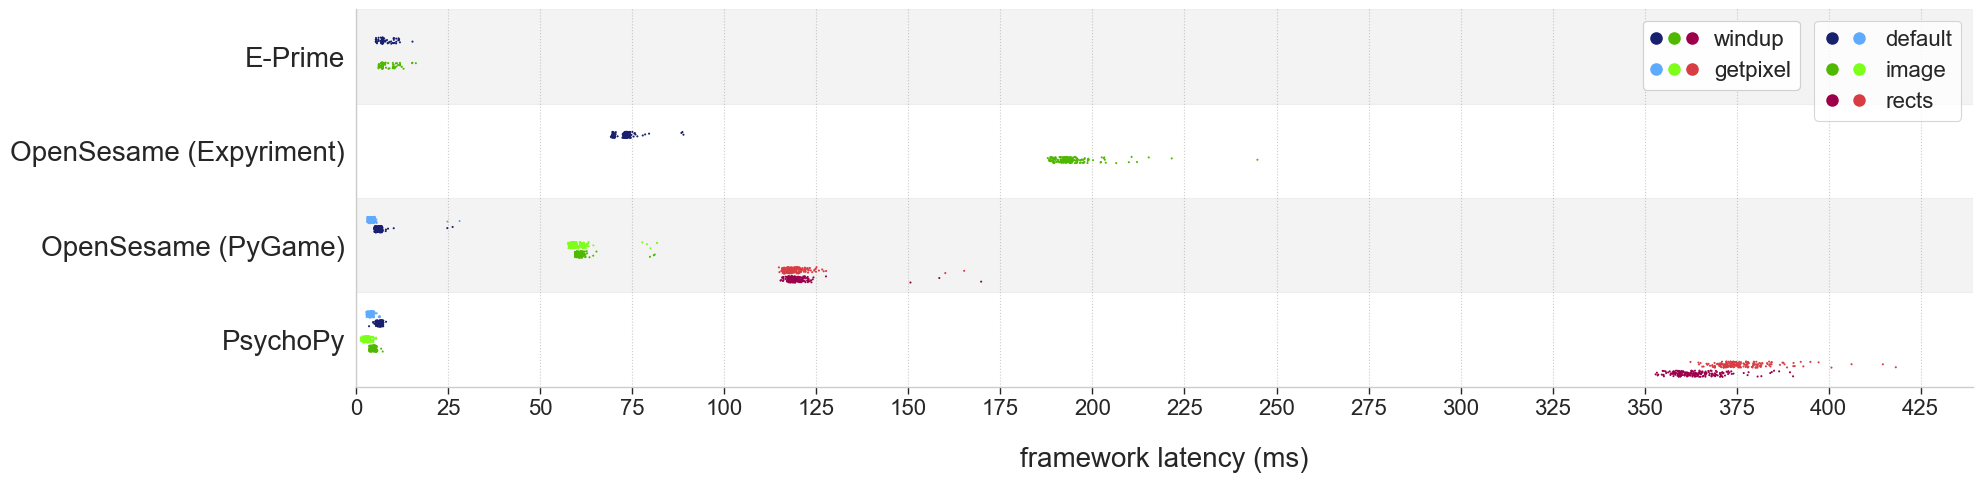

In [114]:
sns.set_theme(style="whitegrid", context="paper", font_scale=1.3, rc={'figure.figsize':(20, 5), "xtick.bottom": True, "grid.linestyle": ":"})

offset = lambda p: transforms.ScaledTranslation(0, p/72., plt.gcf().dpi_scale_trans)
trans = plt.gca().transData

sns.stripplot(data=data[data['program'] == 'windup'], y='framework', x='fw', hue='complexity', hue_order=['default', 'image', 'rects'], dodge=True, palette=PALETTE_DARK, size=1.5, transform=offset(0.07)+trans)
plot = sns.stripplot(data=data[data['program'] == 'getpixel'], y='framework', x='fw', hue='complexity', hue_order=['default', 'image', 'rects'], dodge=True, palette=PALETTE_LIGHT, size=1.5)

# stripped background
for i in range(len(data['framework'].unique())):
    if i % 2 == 0:
        plot.axhspan(i - 0.5, i + 0.5, color=COLOR_NONE, alpha=0.1)
plot.set_ylim(-0.5, len(data['framework'].unique()) - 0.5)

# increase label size
plot.set_xlabel('framework latency (ms)', fontsize=20)
plot.xaxis.labelpad = 20
plot.set_ylabel('')

plot.set_xlim(left=0)
plot.tick_params(axis='y', labelsize=20)
plot.tick_params(axis='x', labelsize=16)
plt.xticks(np.arange(0, max(data['fw']) + 10, 25))
plt.legend(title='', fontsize=20, loc='upper right')

handles, labels = plot.get_legend_handles_labels()
print(handles)
print(labels)

handles_windup = (handles[0], handles[1], handles[2])
handles_getpixel = (handles[3], handles[4], handles[5])

handles_default = (handles[0], handles[3])
handles_image = (handles[1], handles[4])
handles_rects = (handles[2], handles[5])

condition_legend = plot.legend([handles_default, handles_image, handles_rects], ['default', 'image', 'rects'], markerscale=6., loc='upper right', handler_map={tuple: HandlerTuple(ndivide=None)}, fontsize=16)
program_legend = plot.legend([handles_windup, handles_getpixel], ['windup', 'getpixel'], markerscale=6., loc='upper right', handler_map={tuple: HandlerTuple(ndivide=None)}, bbox_to_anchor=(0.9, 1), fontsize=16)
plt.gca().add_artist(condition_legend)
plt.gca().add_artist(program_legend)

plt.gca().invert_yaxis()
sns.despine(bottom = False, left = False)
plt.tight_layout()
plt.savefig("./figures/psycho_results.pdf", format='pdf', bbox_inches='tight')

### Note that EPrime ran with 120hz and active VSYNC

In [115]:
# sns.set_theme(style="whitegrid", context="paper", font_scale=1.3, rc={'figure.figsize':(10, 5), "xtick.bottom": True, "grid.linestyle": ":"})

# plot = sns.stripplot(data=data[data['framework']=='EPrime'], x='program', y='diff', hue='complexity', size=2, dodge=True, palette=[COLOR_BLUE, COLOR_GLUTROT, 'orange', 'green'])
# # plot = sns.boxplot(data=data[data['program'] != 'none'], x='framework', y='diff', hue='program', hue_order=['getpixel', 'bitblt', 'getdbits', 'windup'], dodge=True, palette=['red', 'orange', 'darkred', 'blue'])
# # plot.axes.set_ylim(-25, 50)
# plot.set_xticklabels(plot.get_xticklabels(), rotation=90)

In [116]:
# median table default

data_default = data[data['complexity'] == 'default']

data_rows = []
for framework in data_default['framework'].unique():
    median_getpixel = data_default[(data_default['framework'] == framework) & (data_default['program'] == 'getpixel')]['fw'].median()
    median_windup = data_default[(data_default['framework'] == framework) & (data_default['program'] == 'windup')]['fw'].median()
    data_row = {'framework':framework, 'getpixel':median_getpixel, 'windup':median_windup}
    data_rows.append(data_row)

median_data = pd.DataFrame(data_rows)

df_rounded = median_data.copy()
df_rounded['getpixel'] = df_rounded['getpixel'].astype(float).round(2)
df_rounded['windup'] = df_rounded['windup'].astype(float).round(2)

print(df_rounded.to_latex(index=False,
                  formatters={"name": str.upper},
                  float_format="{:.2f}".format,
))

df_rounded

\begin{tabular}{lrr}
\toprule
framework & getpixel & windup \\
\midrule
E-Prime & NaN & 7.11 \\
OpenSesame (Expyriment) & NaN & 73.42 \\
OpenSesame (PyGame) & 3.99 & 5.95 \\
PsychoPy & 3.97 & 6.37 \\
\bottomrule
\end{tabular}



,framework,getpixel,windup
0,E-Prime,NaN,7.11
1,OpenSesame (Expyriment),NaN,73.42
2,OpenSesame (PyGame),3.99,5.95
3,PsychoPy,3.97,6.37


In [117]:
# median table image

data_default = data[data['complexity'] == 'image']

data_rows = []
for framework in data_default['framework'].unique():
    median_getpixel = data_default[(data_default['framework'] == framework) & (data_default['program'] == 'getpixel')]['fw'].median()
    median_windup = data_default[(data_default['framework'] == framework) & (data_default['program'] == 'windup')]['fw'].median()
    data_row = {'framework':framework, 'getpixel':median_getpixel, 'windup':median_windup}
    data_rows.append(data_row)

median_data = pd.DataFrame(data_rows)

df_rounded = median_data.copy()
df_rounded['getpixel'] = df_rounded['getpixel'].astype(float).round(2)
df_rounded['windup'] = df_rounded['windup'].astype(float).round(2)

print(df_rounded.to_latex(index=False,
                  formatters={"name": str.upper},
                  float_format="{:.2f}".format,
))

df_rounded

\begin{tabular}{lrr}
\toprule
framework & getpixel & windup \\
\midrule
E-Prime & NaN & 7.16 \\
OpenSesame (Expyriment) & NaN & 192.83 \\
OpenSesame (PyGame) & 59.20 & 60.55 \\
PsychoPy & 2.94 & 4.66 \\
\bottomrule
\end{tabular}



,framework,getpixel,windup
0,E-Prime,NaN,7.16
1,OpenSesame (Expyriment),NaN,192.83
2,OpenSesame (PyGame),59.20,60.55
3,PsychoPy,2.94,4.66


In [118]:
# median table rects

data_default = data[data['complexity'] == 'rects']

data_rows = []
for framework in data_default['framework'].unique():
    median_getpixel = data_default[(data_default['framework'] == framework) & (data_default['program'] == 'getpixel')]['fw'].median()
    median_windup = data_default[(data_default['framework'] == framework) & (data_default['program'] == 'windup')]['fw'].median()
    data_row = {'framework':framework, 'getpixel':median_getpixel, 'windup':median_windup}
    data_rows.append(data_row)

median_data = pd.DataFrame(data_rows)

df_rounded = median_data.copy()
df_rounded['getpixel'] = df_rounded['getpixel'].astype(float).round(2)
df_rounded['windup'] = df_rounded['windup'].astype(float).round(2)

print(df_rounded.to_latex(index=False,
                  formatters={"name": str.upper},
                  float_format="{:.2f}".format,
))

df_rounded

\begin{tabular}{lrr}
\toprule
framework & getpixel & windup \\
\midrule
OpenSesame (PyGame) & 118.16 & 119.07 \\
PsychoPy & 375.00 & 363.21 \\
\bottomrule
\end{tabular}



,framework,getpixel,windup
0,OpenSesame (PyGame),118.16,119.07
1,PsychoPy,375.00,363.21
